In [1]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from ssl_fc import Encoder1, Encoder2, Decoder
from m2 import SSL_M2
from misc_ops import *

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from dataset import DataSet
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def split_data(dataset, num_labeled):
    """
    Split dataset into two datasets
    """
    n = dataset.num_examples
    x, y = dataset.next_batch(n)
    x1 = x[xrange(num_labeled),:]
    y1 = y[xrange(num_labeled),:]
    x2 = x[xrange(num_labeled, n),:]
    y2 = y[xrange(num_labeled, n),:]
    d1 = DataSet(x1, y1, dtype=dtypes.float32, reshape=False)
    d2 = DataSet(x2, y2, dtype=dtypes.float32, reshape=False)
    return d1, d2

In [4]:
# Split dataset into labeled and unlabeled
num_labeled = 5000
labeled, unlabeled = split_data(mnist.train, num_labeled)
_, y = labeled.next_batch(num_labeled)
print np.sum(y, axis=0)

[ 522.  564.  503.  539.  445.  429.  513.  520.  482.  483.]


In [25]:
tf.reset_default_graph()

In [26]:
# Train
#sess = tf.InteractiveSession()
#build_encoder1 = Encoder1(500)
#build_encoder2 = Encoder2(500)
#build_decoder = Decoder(500)

# as the number of labeled examples decreases, need alpha to decrease as well?
#model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, labeled, unlabeled,
#            batch_size = 100, z_dim = 50, x_dim = 784, y_dim=10, alpha=55000./10,
#           learning_rate = 1e-3, num_epochs = 20, load=False,
#          checkpoint_name='SSL_M2_checkpoint_5000'
#)
#model.train()

In [27]:
#Load
sess = tf.InteractiveSession()
build_encoder1 = Encoder1(500)
build_encoder2 = Encoder2(500)
build_decoder = Decoder(500)

model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, labeled, unlabeled,
            batch_size = 100, z_dim = 50, x_dim = 784, y_dim=10, alpha=55000./10,
           learning_rate = 1e-3, num_epochs = 20, load=True,
        load_file = "checkpoints/SSL_M2_checkpoint_5000"
              )

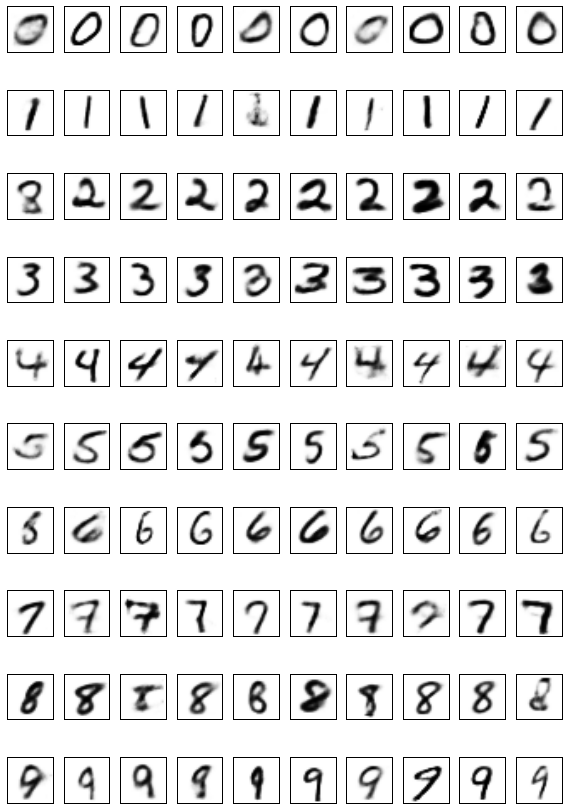

In [28]:
#images, info = mnist.test.next_batch(100)
num_examples = 10
batch_size = 100

labels = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=batch_size, labels=labels)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig('images/SSL_generate_5000')
plt.show()

In [29]:
# Classify validation images
batch_size = 100
num_val = mnist.validation.num_examples
tot = 0
for t in xrange(num_val / batch_size):
    x_val, y_val = mnist.validation.next_batch(batch_size)
    y_pred = model.classify(x_val)
    y_val = np.argmax(y_val, axis=1)
    tot += np.sum(y_pred != y_val)
print "Error: {}".format(float(tot)/num_val)
with open("SSL_err_5000.txt", "w") as text_file:
    text_file.write("Error: {}".format(float(tot)/num_val))

Error: 0.0414


In [ ]:
sess.close()